# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from helper_functions import *

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomCrop, RandomFlip, RandomHeight, RandomWidth, RandomZoom, RandomRotation
from tensorflow.keras import mixed_precision
import tensorflow_datasets as tfds

# Importing Food101 dataset from TensorFlow Datasets

In [2]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4Y3SNQ_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4Y3SNQ_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Investigate our Food101 dataset
* what is the input data shape, dtype, min and max pixel values
* Are the images of a consistent size?
* Are they scaled?
* Are the data in batches?
* How do the labels look like? (are they one-hot or labeled encoded?)
* What are the class names?
* Do labels match the class names?

In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [4]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [5]:
for image, label in train_data.take(3):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Image pixel value, min: {tf.reduce_min(image)}, max: {tf.reduce_max(image)}
  Label dtype: {label.dtype}
  Label value: {label}
  Label value (str format): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image pixel value, min: 0, max: 255
  Label dtype: <dtype: 'int64'>
  Label value: 56
  Label value (str format): huevos_rancheros
  

  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image pixel value, min: 0, max: 255
  Label dtype: <dtype: 'int64'>
  Label value: 76
  Label value (str format): pizza
  

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image pixel value, min: 0, max: 255
  Label dtype: <dtype: 'int64'>
  Label value: 21
  Label value (str format): chocolate_cake
  


In [6]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 66,  79,  53],
        [ 67,  80,  54],
        [ 68,  80,  56],
        ...,
        [ 67,  90,  98],
        [ 64,  87,  95],
        [ 62,  85,  93]],

       [[ 66,  79,  53],
        [ 67,  80,  54],
        [ 68,  80,  56],
        ...,
        [ 82, 102, 111],
        [ 78,  98, 107],
        [ 75,  95, 104]],

       [[ 67,  79,  55],
        [ 68,  80,  56],
        [ 69,  81,  57],
        ...,
        [ 94, 111, 119],
        [ 91, 108, 116],
        [ 88, 105, 113]],

       ...,

       [[ 27,   7,   6],
        [ 26,   6,   5],
        [ 25,   5,   6],
        ...,
        [ 18,  16,  21],
        [ 16,  15,  23],
        [ 16,  15,  23]],

       [[ 28,   7,   6],
        [ 26,   6,   5],
        [ 25,   5,   4],
        ...,
        [ 17,  15,  20],
        [ 16,  13,  22],
        [ 17,  14,  23]],

       [[ 27,   6,   5],
        [ 26,   5,   4],
        [ 25,   5,   4],
        ...,
        [ 16,  14,  1

## Conclusions drawn
* Image sizes are not consisent, we must resize all image tensors for consistency
* Image tensors are in the wrong datatype (typically should be `tf.float32`)
* Images are not scaled (pixel values between 0 & 1), but this is not an issue as we are going to use `EfficientNetB0` as our backbone
* Labels are labeled encoded (during compilation we must use `SpareCaegoricalCrossentropy`)

## Let's visualize an image

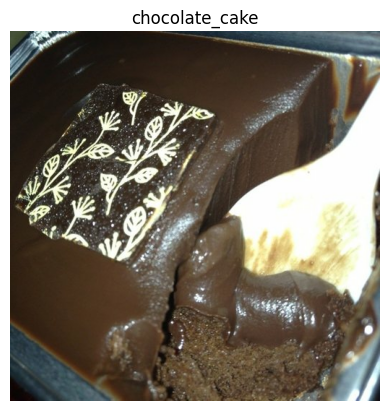

In [7]:
plt.imshow(image)
plt.axis("off")
plt.title(class_names[label.numpy()]);

# Constructing an input pipeline

In [8]:
train_data = train_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing with parallelism
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  # Shuffle, batch, and prefetch

test_data = test_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing with parallelism
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  # Batch and prefetch

In [9]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Feature Extraction Model Construction

This section focuses on building and evaluating a feature extraction model using transfer learning. The process includes:

1. **Preparing Model Callbacks**  
   - Set up callbacks to monitor training and save the best model.

2. **Building the Feature Extraction Model**  
   - Implement the base model with a custom top layer.  
   - Experiment with and without **image augmentation** to compare performance.

3. **Training Experimental Models**  
   - Train each model variation for **5 epochs** to observe initial results.

4. **Evaluating Model Performance**  
   - Compare the validation accuracy and loss of both models.

5. **Selecting the Best Model & Retraining**  
   - Choose the model with superior performance.  
   - Retrain it for a **total of 10 epochs** to improve results.


In [10]:
# creating ModelCheckpoint callback
model_checkpoint = prepare_checkpoint_callback(checkpoint_path="./checkpoints/feature_extraction_without_data_augmentation_5_epochs.weights.h5")

## Setting up mixed_precision

In [11]:
mixed_precision_policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(mixed_precision_policy)

## Consructing the feature extraction model without data augmentation

In [12]:
# instantiating the backbone model
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# finishing the feature extraction architecture
inputs = Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = Dense(len(class_names), name="output_layer")(x)
outputs = Activation("softmax", dtype=tf.float32, name="activation_layer")(x)

feature_extraction_without_data_augmentation_model = Model(inputs, outputs)

# compiling the model
feature_extraction_without_data_augmentation_model.compile(loss=SparseCategoricalCrossentropy(),
                                                         optimizer=Adam(),
                                                         metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
feature_extraction_without_data_augmentation_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_layer (Activation)        │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
for layer in feature_extraction_without_data_augmentation_model.layers:
  print(f"""
        Layer name: {layer.name}
        Layer trainable: {layer.trainable}
        Layer dtype: {layer.dtype}
        Compute dtype: {layer.compute_dtype}
        dytpe policy: {layer.dtype_policy}
  """)


        Layer name: input_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: efficientnetb0
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: global_average_pooling_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: output_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: activation_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float32
        dytpe policy: <DTypePolicy "float32">
  


In [15]:
for layer in feature_extraction_without_data_augmentation_model.layers[1].layers:
  print(f"""
        Layer name: {layer.name}
        Layer trainable: {layer.trainable}
        Layer dtype: {layer.dtype}
        Compute dtype: {layer.compute_dtype}
        dytpe policy: {layer.dtype_policy}
  """)


        Layer name: input_layer
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: rescaling
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: normalization
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: rescaling_1
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: stem_conv_pad
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: stem_conv
        Layer trainable: False
        Layer dtype: float32
        Comp

### Fit the model

In [16]:
history_without_data_aug = feature_extraction_without_data_augmentation_model.fit(train_data,
                                                        epochs=5,
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[model_checkpoint])

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4723 - loss: 2.2853
Epoch 1: val_accuracy improved from -inf to 0.69544, saving model to ./checkpoints/feature_extraction_without_data_augmentation_5_epochs.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 265s 96ms/step - accuracy: 0.4723 - loss: 2.2851 - val_accuracy: 0.6954 - val_loss: 1.1331
Epoch 2/5
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6647 - loss: 1.2968
Epoch 2: val_accuracy improved from 0.69544 to 0.71901, saving model to ./checkpoints/feature_extraction_without_data_augmentation_5_epochs.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 71ms/step - accuracy: 0.6647 - loss: 1.2968 - val_accuracy: 0.7190 - val_loss: 1.0363
Epoch 3/5
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6960 - loss: 1.1525
Epoch 3: val_accuracy improved from 0.71901 to 0.72669, saving model to ./checkpoints/feature_extraction_without_data_augmentation_5_epochs.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 160s 67ms/s

In [17]:
results_without_data_aug = feature_extraction_without_data_augmentation_model.evaluate(test_data)
results_without_data_aug

790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - accuracy: 0.7290 - loss: 0.9882


[0.9860212206840515, 0.7308118939399719]

## Consructing the feature extraction model with data augmentation

In [18]:
# building data_augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2)
], name="data_augmentation_layer")

# instantiating the backbone model
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# finishing the feature extraction architecture
inputs = Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = Dense(len(class_names), name="output_layer")(x)
outputs = Activation("softmax", dtype=tf.float32, name="activation_layer")(x)

feature_extraction_with_data_augmentation_model = Model(inputs, outputs)

# compiling the model
feature_extraction_with_data_augmentation_model.compile(loss=SparseCategoricalCrossentropy(),
                                                         optimizer=Adam(),
                                                         metrics=["accuracy"])

In [19]:
feature_extraction_with_data_augmentation_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation_layer (Sequential) │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_4 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_layer (Activation)        │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
model_checkpoint = prepare_checkpoint_callback(checkpoint_path="./checkpoints/feature_extraction_with_data_augmentation_5_epochs.weights.h5")

In [21]:
for layer in feature_extraction_with_data_augmentation_model.layers:
  print(f"""
        Layer name: {layer.name}
        Layer trainable: {layer.trainable}
        Layer dtype: {layer.dtype}
        Compute dtype: {layer.compute_dtype}
        dytpe policy: {layer.dtype_policy}
  """)


        Layer name: input_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: data_augmentation_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: efficientnetb0
        Layer trainable: False
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: global_average_pooling_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: output_layer
        Layer trainable: True
        Layer dtype: float32
        Compute dtype: float16
        dytpe policy: <DTypePolicy "mixed_float16">
  

        Layer name: activation_layer
        Layer trainable: True
        

### Fit the model

In [22]:
history_with_data_aug = feature_extraction_with_data_augmentation_model.fit(train_data,
                                                                            epochs=5,
                                                                            validation_data=test_data,
                                                                            validation_steps=int(0.15 * len(test_data)),
                                                                            callbacks=[model_checkpoint])

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3973 - loss: 2.6283
Epoch 1: val_accuracy improved from -inf to 0.65440, saving model to ./checkpoints/feature_extraction_with_data_augmentation_5_epochs.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 363s 145ms/step - accuracy: 0.3974 - loss: 2.6281 - val_accuracy: 0.6544 - val_loss: 1.2975
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5734 - loss: 1.6906
Epoch 2: val_accuracy improved from 0.65440 to 0.68167, saving model to ./checkpoints/feature_extraction_with_data_augmentation_5_epochs.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 314s 118ms/step - accuracy: 0.5734 - loss: 1.6906 - val_accuracy: 0.6817 - val_loss: 1.1995
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5989 - loss: 1.5676
Epoch 3: val_accuracy improved from 0.68167 to 0.69015, saving model to ./checkpoints/feature_extraction_with_data_augmentation_5_epochs.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 321s 118ms/step

In [23]:
results_with_data_aug = feature_extraction_with_data_augmentation_model.evaluate(test_data)
results_with_data_aug

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.6934 - loss: 1.1249


[1.126931071281433, 0.693742573261261]

In [24]:
results_with_data_aug, results_without_data_aug

([1.126931071281433, 0.693742573261261],
 [0.9860212206840515, 0.7308118939399719])

# Evaluating both models performances

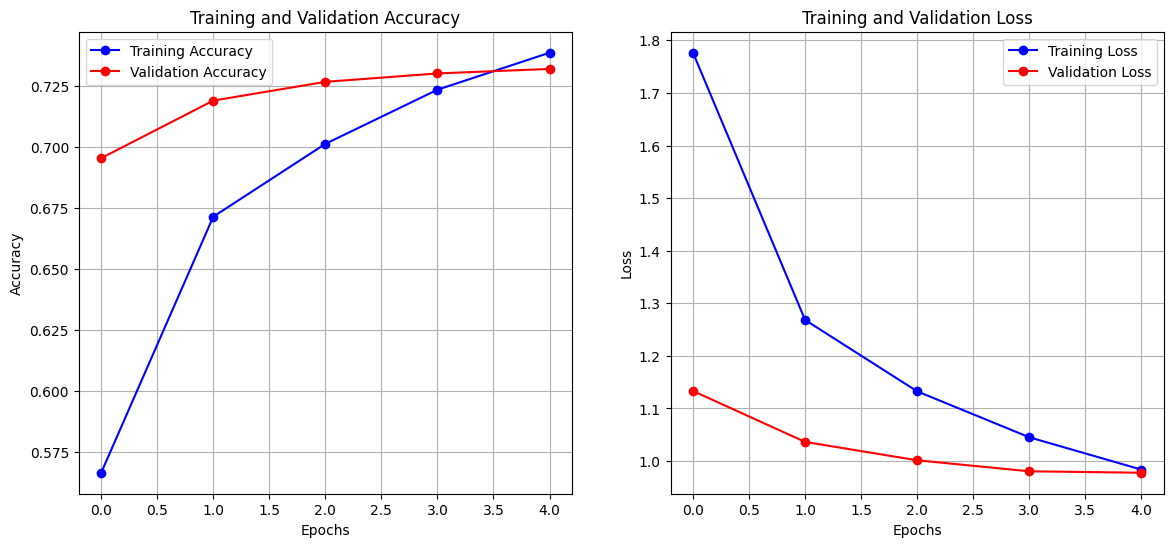

In [25]:
plot_history(history_without_data_aug)

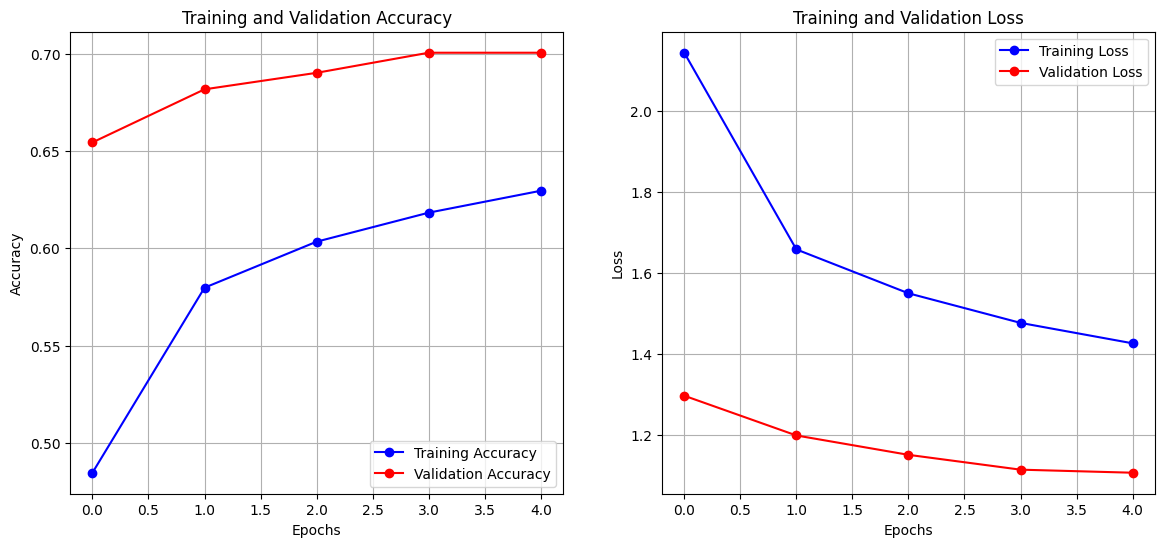

In [26]:
plot_history(history_with_data_aug)